In [1]:
# default_exp viseme_tabular.model

# ML model

> ML model definition and helper functions.

In [16]:
#export
from expoco.core import *
from pathlib import Path
import numpy as np

In [44]:
from expoco.viseme_tabular.data import read_processed_dataset, get_image_path
import matplotlib.pyplot as plt
import pandas as pd
import json

## Saving model state

In [4]:
#export
def save_state_dict(path, state_dict, **training_info):
    "Saves `state_dict` and `training_info` to a new model directory"
    model_id = now()
    output_path = path/f'model_{model_id}'
    output_path.mkdir()
    log = LogFile(output_path/'model.log')
    log('output_path:', output_path.resolve())
    log('training_info:', training_info)
    file_name = output_path/'state_dict.npz'
    log('file_name:', file_name)
    np.savez(file_name, **{k:state_dict[k].detach().cpu().numpy() for k in state_dict})
    np.load(file_name) # check that we didn't need to pickle

- `path` directory to create the new model directory in
    - usually, this will be processed data directory; e.g. `data/viseme_tabular_dataset_20211116_113131/processed_20211117_200746`
    - which would create something like `data/viseme_tabular_dataset_20211116_113131/processed_20211117_200746/model_20211117_201151`
- `state_dict` a pytorch state_dict - i.e. a dictionary of tensors
- `training_info` any info needed to repeat the model training (can also include model metrics etc)

## Loading model state

In [5]:
#export
def load_state_dict(path):
    "Load `state_dict.npz` from `path` (a model directory)"
    return np.load(Path(path)/'state_dict.npz')

# Inference only `numpy` model

We need to write a little code so that we can run inference using a previously saved state dict.

In [6]:
#export 
class NpBatchNorm1d:
    "Applies Batch Normalization"
    # https://github.com/pytorch/pytorch/blob/420b37f3c67950ed93cd8aa7a12e673fcfc5567b/aten/src/ATen/native/Normalization.cpp#L61-L126
    def __init__(self, weight, bias, running_mean, running_var, num_batches_tracked=None):
        self.weight, self.bias = weight, bias
        self.running_mean, self.running_std = running_mean, np.sqrt(running_var + 1e-5)
    def __call__(self, x):
        x = x - self.running_mean
        x = x / self.running_std
        x = x * self.weight
        x = x + self.bias
        return x

In [7]:
#export 
class NpLinear:
    "Applies a linear transformation"
    def __init__(self, weight, bias=None):
        self.weight, self.bias = weight.T, bias
    def __call__(self, x):
        x = x @ self.weight
        if self.bias is not None:
            x = x + self.bias
        return x

In [8]:
#export 
class NpReLU:
    "Applies element wise max of x and zero"
    def __call__(self, x):
        return np.maximum(x, 0)

In [9]:
#export 
class NpModel:
    "A sequential module container"
    def __init__(self, *modules):
        self.modules = modules
    def __call__(self, x):
        for module in self.modules:
            x = module(x)
        return x

In [10]:
#export
def get_class_count(model):
    return model.modules[-1].weight.shape[1]

In [11]:
#export
def load_tabular_model(path):
    "Load `state_dict.npz` from `path` (a model directory) and create a tabular model"
    state_dict = load_state_dict(path)
    # TODO: this only works for the model config we used ... make it a bit more generic
    return NpModel(NpBatchNorm1d(**get_dict_subset(state_dict, 'bn_cont')),
                   NpLinear(**get_dict_subset(state_dict, 'layers.0.0')),
                   NpReLU(),
                   NpBatchNorm1d(**get_dict_subset(state_dict, 'layers.0.2')),
                   NpLinear(**get_dict_subset(state_dict, 'layers.1.0')),
                   NpReLU(),
                   NpBatchNorm1d(**get_dict_subset(state_dict, 'layers.1.2')),
                   NpLinear(**get_dict_subset(state_dict, 'layers.2.0')))

In [12]:
np_model = load_tabular_model('test/data/viseme_tabular_dataset_20211116_113131/processed_20211117_200746/model_20211117_201151')
assert 4 == get_class_count(np_model)

In [30]:
#export 
def create_confusion_matrix(model, df, cont_names, y_name):
    "Confusion matrix as a numpy array"
    class_count = get_class_count(model)
    confusion_matrix = np.zeros([class_count,class_count], dtype=int)
    output = model(df[cont_names].to_numpy())
    preds = np.argmax(output, axis=1)
    targets = df[y_name].to_numpy(dtype=int)
    for p,t in zip(preds, targets):
        confusion_matrix[t][p]+=1
    return confusion_matrix

In [31]:
_metadata, _data, _stats = read_processed_dataset(processed_dataset_path, False)

In [32]:
_data

,0x,0y,1x,1y,2x,2y,5x,5y,11x,11y,...,409y,410x,410y,415x,415y,424x,424y,438x,438y,expression_id
0,0.334207,0.471197,0.324663,0.451899,0.335616,0.453332,0.329575,0.449346,0.334147,0.472152,...,0.455976,0.367652,0.456680,0.364244,0.452572,0.364568,0.439860,0.343441,0.450551,0.0
1,0.342653,0.476807,0.329549,0.459823,0.341589,0.459638,0.333486,0.456180,0.343096,0.477628,...,0.463426,0.372451,0.462349,0.368829,0.459875,0.373407,0.444613,0.348064,0.457250,0.0
2,0.345234,0.474494,0.336296,0.458771,0.345943,0.460298,0.340914,0.454626,0.345198,0.475239,...,0.463137,0.373066,0.463173,0.367778,0.460313,0.370129,0.447766,0.355320,0.456874,0.0
3,0.357477,0.475795,0.352578,0.459969,0.359869,0.459082,0.356275,0.458253,0.357104,0.476500,...,0.461558,0.382777,0.460519,0.377465,0.458397,0.381090,0.442738,0.370275,0.456072,0.0
4,0.374618,0.470386,0.369337,0.458762,0.375636,0.458842,0.372447,0.455905,0.374313,0.470716,...,0.457666,0.394380,0.458246,0.391929,0.454712,0.389567,0.440902,0.382577,0.456951,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-1.962252,-1.990361,-1.954453,-1.988570,-1.961014,-1.990193,-1.955318,-1.987444,-1.962736,-1.990530,...,-1.992752,-1.976856,-1.992620,-1.974970,-1.992879,-1.979089,-1.994454,-1.963614,-1.989365,0.0
9996,-1.962252,-1.990361,-1.954453,-1.988570,-1.961014,-1.990193,-1.955318,-1.987444,-1.962736,-1.990530,...,-1.992752,-1.976856,-1.992620,-1.974970,-1.992879,-1.979089,-1.994454,-1.963614,-1.989365,0.0
9997,-1.962252,-1.990361,-1.954453,-1.988570,-1.961014,-1.990193,-1.955318,-1.987444,-1.962736,-1.990530,...,-1.992752,-1.976856,-1.992620,-1.974970,-1.992879,-1.979089,-1.994454,-1.963614,-1.989365,0.0
9998,-1.962252,-1.990361,-1.954453,-1.988570,-1.961014,-1.990193,-1.955318,-1.987444,-1.962736,-1.990530,...,-1.992752,-1.976856,-1.992620,-1.974970,-1.992879,-1.979089,-1.994454,-1.963614,-1.989365,0.0


In [33]:
path = Path('test/data/viseme_tabular_dataset_20211116_113131/processed_20211117_200746')
_metadata, _data, _stats = read_processed_dataset(processed_dataset_path, False)
confusion_matrix = create_confusion_matrix(np_model, _data, _data.columns[:-1], _data.columns[-1])
confusion_matrix

array([[4000,    0,    0,    0],
       [   0, 1989,    0,   11],
       [   0,    2, 1989,    9],
       [   0,    2,   17, 1981]])

In [34]:
#export
def plot_confusion_matrix(model, df, cont_names, y_name):
    "Plot a confusion matrix using matplotlib"
    confusion_matrix = create_confusion_matrix(model, df, cont_names, y_name)
    class_count = get_class_count(model) # class_count might not be the same as len(class_ids)
    class_ids, class_labels = VisemeConfig().get_class_ids_and_labels()
    fig, ax = plt.subplots(figsize=(9,9))
    ax.matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.8)
    # ax.xaxis.set_ticks_position('bottom') # must be after matshow
    ax.yaxis.set_label_position('right')
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            ax.text(x=j, y=i,s=confusion_matrix[i, j], va='center', ha='center', size='xx-large')
    plt.title('Confusion Matrix', fontsize=14)
    plt.xlabel('Predicted', fontsize=12)
    plt.ylabel('Actual', fontsize=12)
    tick_marks = np.arange(class_count)
    plt.xticks(tick_marks, class_labels[:class_count], rotation=90)
    plt.yticks(tick_marks, class_labels[:class_count], rotation=0)
    plt.show()

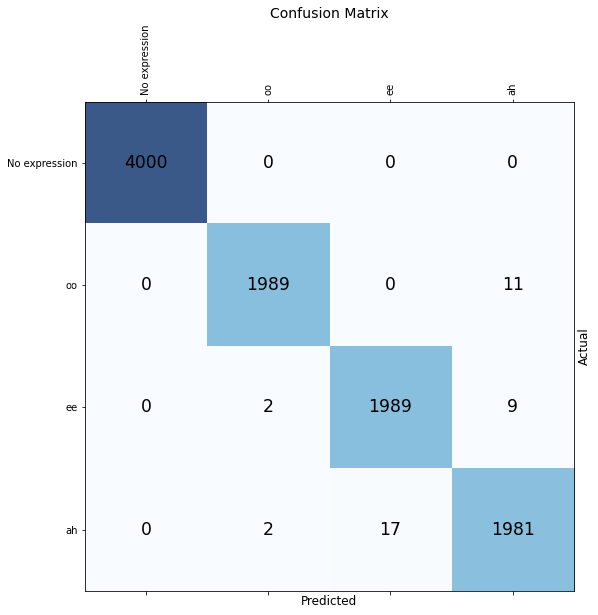

In [35]:
plot_confusion_matrix(np_model, _data, _data.columns[:-1], _data.columns[-1])

In [36]:
#export 
def get_idxs_of_interest(model, df, cont_names, y_name, target_of_interest, pred_of_interest):
    "Indeces in `df` where `df[y_name]` had `target_of_interest` but the model predicted `pred_of_interest`"
    viseme_config = VisemeConfig()
    output = model(df[cont_names].to_numpy())
    preds = np.argmax(output, axis=1)
    targets = df[y_name].to_numpy()
    idxs = []
    print('target_of_interest', viseme_config.get_class_label(target_of_interest),
          'pred_of_interest', viseme_config.get_class_label(pred_of_interest))
    print('overall accuracy', (targets==preds).sum() / len(targets))
    _filter = targets==target_of_interest
    print('accuracy for target_of_interest',(targets[_filter]==preds[_filter]).sum() / _filter.sum())
    for i, (p,t) in enumerate(zip(preds,targets)):
        if t==target_of_interest and p==pred_of_interest:
            idxs.append(i)
    return idxs


- `target_of_interest` class ID of the target we're interested in
- `pred_of_interest` class ID of the prediction we're interested in

In [40]:
idxs = get_idxs_of_interest(np_model, _data, _data.columns[:-1], _data.columns[-1], 2, 3)

target_of_interest ee pred_of_interest ah
overall accuracy 0.9959
accuracy for target_of_interest 0.9945


We can `df.iloc[idxs]` and look at the rows that the model saw.

We can also use `get_image_path` &darr; to get `img_path`, input values before processing etc

In [54]:
pd.DataFrame(dict(idx=idxs, image_path=[str(get_image_path(processed_dataset_path, i))[44:] for i in idxs]))

,idx,image_path
0,6515,capture_session\viseme_20211116_112032_2\116.jpeg
1,6523,capture_session\viseme_20211116_112032_2\124.jpeg
2,6530,capture_session\viseme_20211116_112032_2\131.jpeg
3,6531,capture_session\viseme_20211116_112032_2\132.jpeg
4,6534,capture_session\viseme_20211116_112032_2\135.jpeg
5,6539,capture_session\viseme_20211116_112032_2\140.jpeg
6,8513,capture_session\viseme_20211116_112405_2\114.jpeg
7,9452,capture_session\viseme_20211116_112552_2\53.jpeg
8,9453,capture_session\viseme_20211116_112552_2\54.jpeg


In [55]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_core.ipynb.
Converted 01a_camera_capture.ipynb.
Converted 10a_viseme_tabular_identify_landmarks.ipynb.
Converted 10b_viseme_tabular_capture_session.ipynb.
Converted 10c_viseme_tabular_data.ipynb.
Converted 10d_viseme_tabular_model.ipynb.
Converted 10e_viseme_tabular_train_model.ipynb.
Converted 10f_test_np_model.ipynb.
Converted 20a_gui_capture_command.ipynb.
Converted 20a_gui_main.ipynb.
Converted 70_cli.ipynb.
Converted index.ipynb.
Converted project_lifecycle.ipynb.
